In [114]:
import duckdb
con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/data/deadlock.db")
raw_con = duckdb.connect("c:/Code/Local Code/deadlock_match_prediction/match_player_raw.duckdb")

In [ ]:
result = raw_con.execute("SELECT count(*) FROM staging_cleaned").fetchall()
print(result)

In [94]:
con.close()
raw_con.close()

In [ ]:
match_df = con.execute("SELECT * FROM matches").fetchdf()
match_ids = match_df['match_id'].unique().tolist()

# Register match_df as a temporary DuckDB view
raw_con.register("match_df", match_df)

query = """
    SELECT 
        player_count,
        COUNT(*) AS match_count
    FROM (
        SELECT 
            s.match_id,
            COUNT(*) AS player_count
        FROM staging_cleaned s
        JOIN match_df m ON s.match_id = m.match_id
        GROUP BY s.match_id
    )
    GROUP BY player_count
    ORDER BY player_count
"""

query2 = """
    SELECT COUNT(DISTINCT match_id) from match_df;
"""
result = raw_con.execute(query).fetchdf()
print(result)
result2 = raw_con.execute(query2).fetchdf()
print(result2)

In [ ]:
    """Formats raw match_info to be combined with raw_match_players
    Combined data will live in deadlock.db.player_matches_history table
    """
raw_con.execute(f"""
        CREATE OR REPLACE TABLE high_quality_matches AS
        SELECT match_id, start_time, game_mode, match_mode, won
        FROM 'match_info_history'
        WHERE (average_badge_team0 + average_badge_team1) / 2 > 75
    """)
    result = raw_con.execute("Select count(*) from high_quality_matches").fetchone()[0]
    print(f"High quality matches count: {result}")

In [ ]:
raw_con.execute("CREATE OR REPLACE TABLE matches_for_training AS SELECT * FROM match_df")


In [ ]:
result = raw_con.execute("select * from staging_cleaned limit 1").fetchdf()
print(result)

In [ ]:
result = con.execute("SELECT count(distinct account_id) FROM player_matches").fetchdf()
print(result)

In [ ]:
result = raw_con.execute("""SELECT COUNT(*)
FROM staging_cleaned
WHERE match_id IN (
    SELECT DISTINCT match_id FROM matches_for_training
);""").fetchall()
print(result)

In [ ]:
raw_con.execute("""SELECT COUNT(*) AS non_unique_match_ids
FROM (
    SELECT s.account_id
    FROM staging_cleaned s
    JOIN matches_for_training m ON s.match_id = m.match_id
    GROUP BY s.account_id
    HAVING COUNT(*) > 1
);""").fetchall()

*** Creates / replaces filtered_player_matches, completing with data from staging_cleared, where match_id matches matches_for_Training

This should create match history for all players in matches_for_training

In [ ]:
raw_con.execute("""
    CREATE OR REPLACE TABLE filtered_player_matches AS
SELECT
    s.account_id,
    s.match_id,
    s.hero_id,
    s.team,
    s.kills,
    s.deaths,
    s.assists,
    s.denies,
    s.net_worth,
    s.won,
    s.start_time,
FROM staging_cleaned s
WHERE s.account_id IN (
    SELECT DISTINCT account_id 
    FROM dup_player_matches
);
                """)

In [ ]:
query1 = raw_con.execute("SELECT count(distinct match_id) from filtered_player_matches").fetchall()
query2 = raw_con.execute("SELECT count(*) from filtered_player_matches").fetchall()
print(query1)
print(query2)

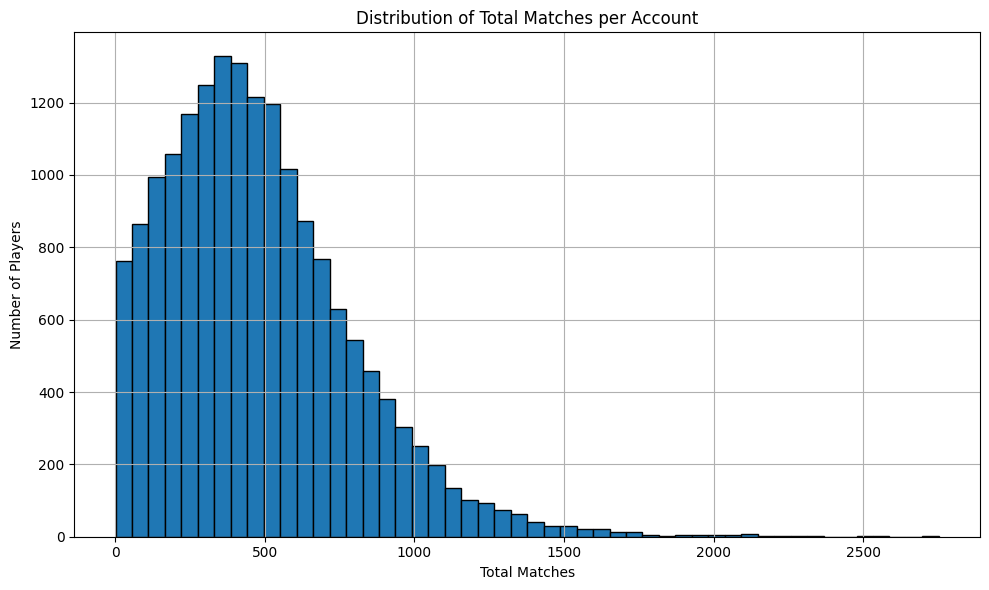

In [96]:
import duckdb
import matplotlib.pyplot as plt

df = raw_con.execute("""
    SELECT 
        account_id,
        COUNT(match_id) AS total_matches
    FROM player_matches
    GROUP BY account_id
""").fetchdf()

# Histogram for total matches
plt.figure(figsize=(10, 6))
plt.hist(df['total_matches'], bins=50, edgecolor='black')
plt.title('Distribution of Total Matches per Account')
plt.xlabel('Total Matches')
plt.ylabel('Number of Players')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Fetch total match counts per player
df = raw_con.execute("""
    SELECT account_id, COUNT(*) AS total_matches
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Calculate 95th percentile
p95 = np.percentile(df["total_matches"], 95)

# Plot
plt.figure(figsize=(10, 5))
plt.hist(df[df["total_matches"] <= p95]["total_matches"], bins=50)
plt.title("Player Total Matches (≤95th percentile)")
plt.xlabel("Total Matches")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

In [ ]:
df = raw_con.execute("""SELECT COUNT(*) 
FROM staging_cleaned s
INNER JOIN matches_for_training m ON s.match_id = m.match_id;""").fetchdf()
print(f"{df.columns}\n\n {len(df)}")

Duplicate main.player_matches into raw_data.dup_player_matches

In [ ]:
df = con.execute("""
    select * from player_matches""").fetchdf()
print(f"{df.columns}\n\n {len(df)}")
raw_con.execute("""
    INSERT into dup_player_matches
    SELECT * FROM df
                """)

In [ ]:
result = raw_con.execute("SELECT count(*) from dup_player_matches").fetchdf()
print(result)

In [ ]:
con.execute("""
    UPDATE player_matches
    SET won = (
        SELECT CASE 
            WHEN player_matches.team = m.winning_team THEN 1 
            ELSE 0 
            END
        FROM matches m
        WHERE player_matches.match_id = m.match_id
);  """)

In [ ]:
oldest_fpm_match_start = raw_con.execute("""
    SELECT hqm.start_time
    FROM match_info_history hqm
    WHERE hqm.match_id = (
        SELECT MIN(match_id)
        FROM filtered_player_matches
    )
""").fetchone()

oldest_high_quality = raw_con.execute("""
    SELECT MIN(start_time) FROM high_quality_matches
""").fetchone()

print("Start time from lowest match_id:", oldest_fpm_match_start[0])
print("Oldest start time overall:", oldest_high_quality[0])

In [ ]:
result = raw_con.execute("SELECT count(*) from dup_player_matches limit 1").fetchdf()
print(result)

Count and display layout of multiple tables

In [ ]:
result = raw_con.execute("SELECT COUNT(*) FROM matches_for_training").fetchdf()
print(f"matches_for_training: {result}")
result = raw_con.execute("SELECT * FROM matches_for_training LIMIT 1").fetchdf()
print(f"matches_for_training: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM dup_player_matches").fetchdf()
print(f"\n\ndup_player_matches: {result}")
result = raw_con.execute("SELECT * FROM dup_player_matches LIMIT 1").fetchdf()
print(f"dup_player_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM filtered_player_matches").fetchdf()
print(f"\n\nfiltered_player_matches: {result}")
result = raw_con.execute("SELECT * FROM filtered_player_matches LIMIT 1").fetchdf()
print(f"filtered_player_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM high_quality_matches").fetchdf()
print(f"\n\nhigh_quality_matches: {result}")
result = raw_con.execute("SELECT * FROM high_quality_matches LIMIT 1").fetchdf()
print(f"high_quality_matches: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM staging_cleaned").fetchdf()
print(f"\nstaging_cleaned: {result}")
result = raw_con.execute("SELECT * FROM staging_cleaned LIMIT 1").fetchdf()
print(f"staging_cleaned: {result}")

result = raw_con.execute("SELECT COUNT(*) FROM match_info_history").fetchdf()
print(f"\n match_info_history: {result}")
result = raw_con.execute("SELECT * FROM match_info_history LIMIT 1").fetchdf()
print(f"match_info_history: {result}")

# What distinct account_ids are in filtered_player_matches but not in dup_player_matches
Expectation should be zero.

In [ ]:
unique_count = raw_con.execute("""
    SELECT COUNT(DISTINCT fpm.account_id) AS unique_count
    FROM filtered_player_matches fpm
    WHERE fpm.account_id NOT IN (
        SELECT account_id FROM dup_player_matches
    )
""").fetchone()

print("Unique account_ids not in dup_player_matches:", unique_count[0])

## How many matches of history for each player in filtered_player_matches
count occurance of each account_id in filtered_player_matches


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch data
result = raw_con.execute("""
    SELECT account_id, COUNT(*) AS match_count
    FROM filtered_player_matches
    GROUP BY account_id
""").fetchdf()

# Bin match counts into buckets of 50
bins = range(0, result['match_count'].max() + 101, 100)
result['match_bucket'] = pd.cut(result['match_count'], bins=bins, right=False)

# Count players in each bucket
bucket_counts = result['match_bucket'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Match Count Bucket')
plt.ylabel('Number of Players')
plt.title('Player Distribution by Match Count Buckets (50 per bucket)')
plt.tight_layout()
plt.show()

# Combine data and insert into main.player_matches_history


In [76]:
con.execute(f"""
    drop table if exists player_matches_history;""")


In [77]:
from services import database_functions as dbf

dbf.create_player_matches_history(con)

In [78]:
raw_con.execute(f"""
    ALTER TABLE filtered_player_matches ADD COLUMN prior_win_loss_streak VARCHAR;    
            """)

CatalogException: Catalog Error: Column with name prior_win_loss_streak already exists!

In [54]:
raw_con.execute("""
    update filtered_player_matches
    set start_time = match_info_history.start_time
    from match_info_history
    where filtered_player_matches.match_id = match_info_history.match_id    
                """)

In [85]:
query = raw_con.execute("SELECT * from filtered_player_matches LIMIT 5").fetchdf()
print(query)

   account_id  match_id  hero_id  team  kills  deaths  assists  denies  \
0   974492784  18795645       31     1     14       6       14      28   
1    78301955  18795650       31     0      5       8       12      18   
2    12185751  18795674        7     0      8      13       26      19   
3   127837639  18795674       35     1     15       7       14       9   
4   257349079  18795674       17     0     22       6       18      15   

   net_worth    won          start_time prior_win_loss_streak  
0      46259   True 2024-09-29 23:49:53                  None  
1      36871  False 2024-09-29 23:49:53                  None  
2      65119  False 2024-09-29 23:50:00                  None  
3     106773   True 2024-09-29 23:50:00                  None  
4      61024  False 2024-09-29 23:50:00                  None  


Copy data from filtered_player_matches to player_matches_history

In [90]:
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import os
import time
def direct_copy(raw_con, con):
    """
    Transfer all data in one operation - requires sufficient memory
    """
    start_time = time.time()
    
    # Check source
    total_count = raw_con.execute("SELECT COUNT(*) FROM filtered_player_matches").fetchone()[0]
    print(f"Source table contains {total_count} rows")
    
    if total_count == 0:
        print("Source table is empty - nothing to transfer")
        return 0
    
    # Create target table
    con.execute("DROP TABLE IF EXISTS player_matches_history")
    
    try:
        print("Fetching all data...")
        fetch_start = time.time()
        all_data = raw_con.execute("SELECT * FROM filtered_player_matches").fetchdf()
        fetch_end = time.time()
        print(f"Fetched {len(all_data)} rows in {fetch_end - fetch_start:.2f} seconds")
        
        # Insert all data
        print("Inserting data...")
        insert_start = time.time()
        con.register("all_data", all_data)
        con.execute("""
            CREATE TABLE player_matches_history AS
            SELECT * FROM all_data
        """)
        insert_end = time.time()
        print(f"Inserted data in {insert_end - insert_start:.2f} seconds")
        
        # Verify
        final_count = con.execute("SELECT COUNT(*) FROM player_matches_history").fetchone()[0]
        print(f"Final row count in target table: {final_count}")
    except Exception as e:
        print(f"Error during transfer: {e}")
        import traceback
        traceback.print_exc()
    
    end_time = time.time()
    print(f"Total transfer completed in {end_time - start_time:.2f} seconds")
    
    return final_count
direct_copy(raw_con, con)

Source table contains 8316105 rows
Fetching all data...
Fetched 8316105 rows in 0.75 seconds
Inserting data...
Inserted data in 1.29 seconds
Final row count in target table: 8316105
Total transfer completed in 2.05 seconds


8316105

In [89]:
df = raw_con.execute("""
    select count(account_id) from filtered_player_matches""").fetchdf()
print(df)

   count(account_id)
0            8316105


In [91]:
df = con.execute("""
    select * from player_matches_history LIMIT 1""").fetchdf()
print(df)

   account_id  match_id  hero_id  team  kills  deaths  assists  denies  \
0   974492784  18795645       31     1     14       6       14      28   

   net_worth   won          start_time  prior_win_loss_streak  
0      46259  True 2024-09-29 23:49:53                   <NA>  


In [93]:
df = con.execute("""
    select count(start_time) from player_matches_history""").fetchdf()
print(df)

   count(start_time)
0            8316105


In [ ]:
con.execute("ALTER TABLE player_matches_history ADD COLUMN start_time TIMESTAMP")

In [ ]:
query = f"""
    UPDATE player_matches_history
    SET start_time = match_info_history.start_time
    FROM match_info_history
    WHERE player_matches_history.match_id = match_info_history.match_id
    """


In [ ]:
query = raw_con.execute(f"""
    select start_time from match_info_history
    order by start_time asc
    limit 20
    """).fetchdf()
print(query)

In [ ]:
query = raw_con.execute("""
    SELECT count(*)
    FROM match_info_history
    WHERE start_time = ''
    """).fetchdf()
print(query)

In [109]:
query2 = con.execute("""
        select count(*) from player_matches_history""").fetchone()
print("player_matches_history count: ", query2)
query = con.execute("""
        select count(*) from player_rolling_stats""").fetchone()
print("player_rolling_stats count: ", query)

print("difference: ", query2[0] - query[0])

player_matches_history count:  (8316105,)
player_rolling_stats count:  (6187631,)
difference:  2128474


In [112]:
query3 = con.execute("""
        select * from player_matches_history limit 1""").fetchdf()
print("player_matches_history count: ", query3)

player_matches_history count:     account_id  match_id  hero_id  team  kills  deaths  assists  denies  \
0   974492784  18795645       31     1     14       6       14      28   

   net_worth   won          start_time  prior_win_loss_streak  
0      46259  True 2024-09-29 23:49:53                   <NA>  


In [117]:
con.execute("ALTER TABLE player_rolling_stats ADD COLUMN prior_win_loss_streak VARCHAR")

In [118]:
con.close()
raw_con.close()